In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil
import cv2
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import keras.utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.utils import to_categorical



In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
data_folder = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation"
image_dir = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation\train_validation"


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv(data_folder + '\list_partition.csv')
df = df.drop('Unnamed: 0', axis=1)
df['gender'].value_counts()

gender
0    3843
2    3773
1    3751
Name: count, dtype: int64

In [ ]:
EPOCHS = 5
N_SPLIT = 5

#storing the average of all predictions
main_pred = []
data_kfold = pd.DataFrame()

#Creating X, Y for training
train_y = df['gender']
train_x = df['image']

In [ ]:
#Initializing Data Generators
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#KFold
kf = StratifiedKFold(n_splits = N_SPLIT, shuffle = True, random_state = 42)

In [ ]:
Y = df[['gender']]

In [ ]:
# Convert integer labels to string labels using .loc
Y.loc[:, 'gender'] = Y['gender'].astype(str)

# Verify the data type of the 'gender' column
print(Y['gender'].dtype)

object


In [ ]:
y_val = Y.iloc[10]


In [ ]:
# Convert integer labels to string labels using .loc
df.loc[:, 'gender'] = df['gender'].astype(str)

# Verify the data type of the 'gender' column
print(df['gender'].dtype)

object


In [ ]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
batch_size = 64
target_size = (224, 224)
input_shape=(224, 224, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

import efficientnet.keras as efn
import tensorflow

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in kf.split(np.zeros(train_x.shape[0]),Y):

    print("--------------------")
    print("Fold:", fold_var)

    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]

    train_data_generator = train_datagen.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "image", y_col = "gender",
                               class_mode = "categorical", shuffle = True, target_size = (224, 224))
    valid_data_generator  = validation_datagen.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "image", y_col = "gender",
                            class_mode = "categorical", shuffle = True, target_size = (224, 224))

    # CREATE NEW MODEL
    base_model = efn.EfficientNetB4(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

    # Freezing Layers

    for layer in base_model.layers:
        layer.trainable = False

    model = tensorflow.keras.Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    #x = Dropout(0.5)(x)
    model.add(Dense(3, activation="softmax"))

    #model = Model(base_model.input, predictions)

    #Compile the model
    model.compile(optimizer= "adam", loss="categorical_crossentropy",metrics=['accuracy'])


    #CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
                            monitor='val_accuracy', verbose=1,
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]


    # Model Checkpoint
    model_path='./output/gender_model.h5'
    checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                                   save_weights_only=False, mode='auto',save_freq='epoch')
    callback_list=[checkpointer]

    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(train_data_generator,
                epochs=EPOCHS,
                callbacks=callback_list,
                validation_data=valid_data_generator)
    #PLOT HISTORY
    #		:
    #		:

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("./output/gender_model.h5")

    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

--------------------
Fold: 1
Found 7731 validated image filenames belonging to 3 classes.
Found 1950 validated image filenames belonging to 3 classes.


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1362 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 324 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


71892840/71892840 [==============================] - 25s 0us/step
Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 1.4635 - accuracy: 0.8670
Epoch 1: loss improved from inf to 1.46352, saving model to ./output\gender_model.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 895s 4s/step - loss: 1.4635 - accuracy: 0.8670 - val_loss: 0.2313 - val_accuracy: 0.9231
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9195
Epoch 2: loss improved from 1.46352 to 0.26848, saving model to ./output\gender_model.h5
242/242 [==============================] - 827s 3s/step - loss: 0.2685 - accuracy: 0.9195 - val_loss: 0.2427 - val_accuracy: 0.9277
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.9269
Epoch 3: loss did not improve from 0.26848
242/242 [==============================] - 815s 3s/step - loss: 0.2905 - accuracy: 0.9269 - val_loss: 0.2201 - val_accuracy: 0.9313
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9410
Epoch 4: loss improved from 0.26848 to 0.20250, saving model to ./output\gender_model.h5
242/242 [==============================] - 823s 3s/step - loss: 0.2025 - accuracy: 0.9410 - val_lo

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1358 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 328 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 1.3688 - accuracy: 0.8675
Epoch 1: loss improved from inf to 1.36876, saving model to ./output\gender_model.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 943s 4s/step - loss: 1.3688 - accuracy: 0.8675 - val_loss: 0.2524 - val_accuracy: 0.9106
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9209
Epoch 2: loss improved from 1.36876 to 0.27438, saving model to ./output\gender_model.h5
242/242 [==============================] - 933s 4s/step - loss: 0.2744 - accuracy: 0.9209 - val_loss: 0.3183 - val_accuracy: 0.9234
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.9239
Epoch 3: loss did not improve from 0.27438
242/242 [==============================] - 886s 4s/step - loss: 0.2945 - accuracy: 0.9239 - val_loss: 0.2061 - val_accuracy: 0.9322
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9338
Epoch 4: loss improved from 0.27438 to 0.18765, saving model to ./output\gender_model.h5
242/242 [==============================] - 909s 4s/step - loss: 0.1877 - accuracy: 0.9338 - val_lo

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1365 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 321 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
242/242 [==============================] - ETA: 0s - loss: 1.5382 - accuracy: 0.8666
Epoch 1: loss improved from inf to 1.53825, saving model to ./output\gender_model.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


242/242 [==============================] - 901s 4s/step - loss: 1.5382 - accuracy: 0.8666 - val_loss: 0.3406 - val_accuracy: 0.9139
Epoch 2/5
242/242 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.9226
Epoch 2: loss improved from 1.53825 to 0.25620, saving model to ./output\gender_model.h5
242/242 [==============================] - 902s 4s/step - loss: 0.2562 - accuracy: 0.9226 - val_loss: 0.2538 - val_accuracy: 0.9257
Epoch 3/5
242/242 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9361
Epoch 3: loss improved from 0.25620 to 0.19274, saving model to ./output\gender_model.h5
242/242 [==============================] - 847s 3s/step - loss: 0.1927 - accuracy: 0.9361 - val_loss: 0.2188 - val_accuracy: 0.9401
Epoch 4/5
242/242 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9347
Epoch 4: loss did not improve from 0.19274
242/242 [==============================] - 832s 3s/step - loss: 0.2159 - accuracy: 0.9347 - val_lo

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1336 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 350 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 1.5693 - accuracy: 0.8724
Epoch 1: loss improved from inf to 1.56934, saving model to ./output\gender_model.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 854s 3s/step - loss: 1.5693 - accuracy: 0.8724 - val_loss: 0.2402 - val_accuracy: 0.9319
Epoch 2/5
243/243 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9229
Epoch 2: loss improved from 1.56934 to 0.22560, saving model to ./output\gender_model.h5
243/243 [==============================] - 848s 3s/step - loss: 0.2256 - accuracy: 0.9229 - val_loss: 0.1994 - val_accuracy: 0.9355
Epoch 3/5
243/243 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9328
Epoch 3: loss improved from 0.22560 to 0.22171, saving model to ./output\gender_model.h5
243/243 [==============================] - 836s 3s/step - loss: 0.2217 - accuracy: 0.9328 - val_loss: 0.2541 - val_accuracy: 0.9329
Epoch 4/5
243/243 [==============================] - ETA: 0s - loss: 0.1854 - accuracy: 0.9395
Epoch 4: loss improved from 0.22171 to 0.18537, saving model to ./output\gender_model.h5
243/243 [==============================] - 836s 3s/s

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1323 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 363 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 1.3642 - accuracy: 0.8687
Epoch 1: loss improved from inf to 1.36422, saving model to ./output\gender_model.h5


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 849s 3s/step - loss: 1.3642 - accuracy: 0.8687 - val_loss: 0.2962 - val_accuracy: 0.9199
Epoch 2/5
243/243 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.9184
Epoch 2: loss improved from 1.36422 to 0.25514, saving model to ./output\gender_model.h5
243/243 [==============================] - 839s 3s/step - loss: 0.2551 - accuracy: 0.9184 - val_loss: 0.2840 - val_accuracy: 0.9220
Epoch 3/5
243/243 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9279
Epoch 3: loss improved from 0.25514 to 0.23300, saving model to ./output\gender_model.h5
243/243 [==============================] - 843s 3s/step - loss: 0.2330 - accuracy: 0.9279 - val_loss: 0.2137 - val_accuracy: 0.9319
Epoch 4/5
243/243 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9368
Epoch 4: loss improved from 0.23300 to 0.19107, saving model to ./output\gender_model.h5
243/243 [==============================] - 859s 4s/s

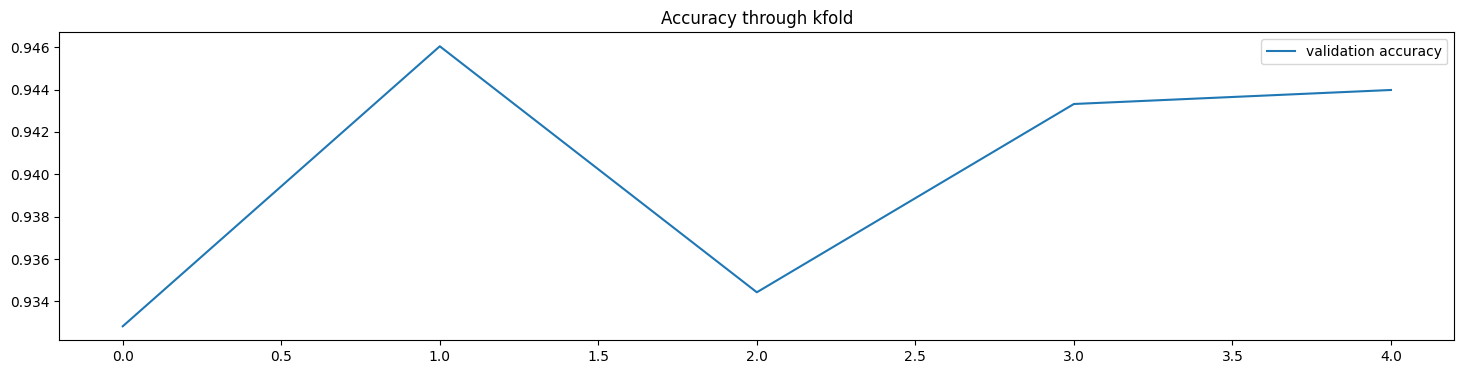

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(VALIDATION_ACCURACY, label = 'validation accuracy')
plt.legend()
plt.title('Accuracy through kfold')
plt.show()

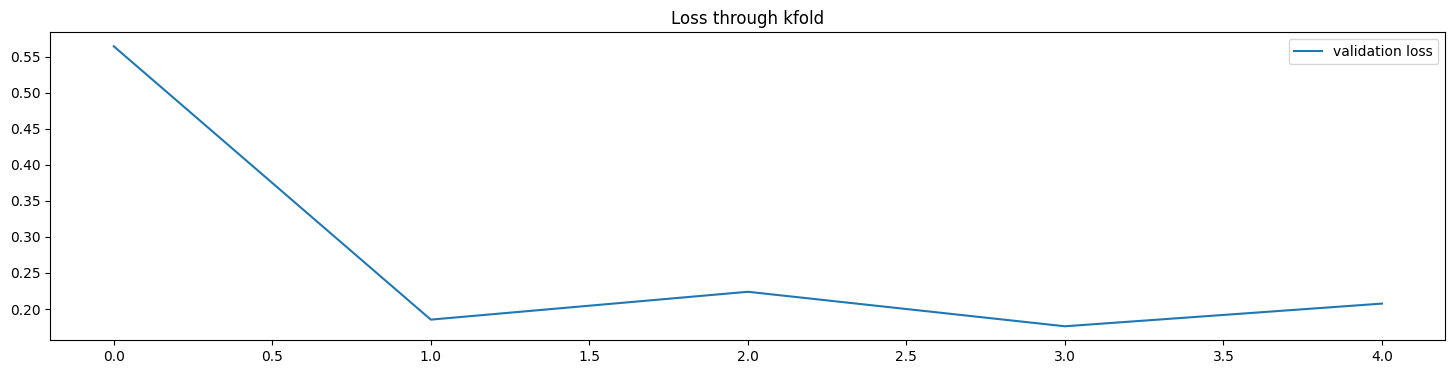

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(VALIDATION_LOSS, label = 'validation loss')
plt.legend()
plt.title('Loss through kfold')
plt.show()

In [ ]:
# CREATE NEW MODEL
base_model = efn.EfficientNetB4(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

# Freezing Layers

for layer in base_model.layers:
    layer.trainable = False

model = tensorflow.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(3, activation="softmax"))

# LOAD BEST MODEL to evaluate the performance of the model
model.load_weights("./output/gender_model.h5")

In [ ]:
partition_df = pd.read_csv(r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\dataset_partition.csv")

train_df = partition_df.loc[partition_df['partition'] == 0]
validation_df = partition_df.loc[partition_df['partition'] == 1]
test_df = partition_df.loc[partition_df['partition'] == 2]

train_df = train_df.drop('Unnamed: 0', axis=1)
test_df = test_df.drop('Unnamed: 0', axis=1)
validation_df = validation_df.drop('Unnamed: 0', axis=1)

In [ ]:
from skimage import io

In [ ]:
test_folder = r"C:\Users\Admin\Documents\TESI DATASET\dataset_definitivo\train_test_validation\test\\"

def generate_df(attr):
    x_ = []
    y_ = []

    for index, target in test_df.iterrows():
        im = io.imread(test_folder + target['image'])
        #im = cv2.imread(r"C:\Users\Admin\Documents\TESI DATASET\balanced dataset\img_predictions" + target['image_id'])
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (224, 224)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

In [ ]:
# Test Data
from sklearn.metrics import f1_score
x_test, y_test = generate_df('gender')

# generate prediction
model_predictions = [np.argmax(model.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average='weighted'))

1/1 [==============================] - 0s 200ms/step
Model Evaluation
Test accuracy: 93.2384%
f1_score: 0.9322451387758491


In [ ]:
from sklearn import metrics
print("Accuracy score:{:.2f}".format(metrics.accuracy_score(y_test, model_predictions)))
print("Classification Results:\n{}".format(metrics.classification_report(y_test, model_predictions)))

Accuracy score:0.93
Classification Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       599
           1       0.88      0.93      0.91       558
           2       0.94      0.87      0.90       529

    accuracy                           0.93      1686
   macro avg       0.93      0.93      0.93      1686
weighted avg       0.93      0.93      0.93      1686



In [ ]:
print(metrics.confusion_matrix(y_test, model_predictions))

[[589   6   4]
 [  9 521  28]
 [  5  62 462]]


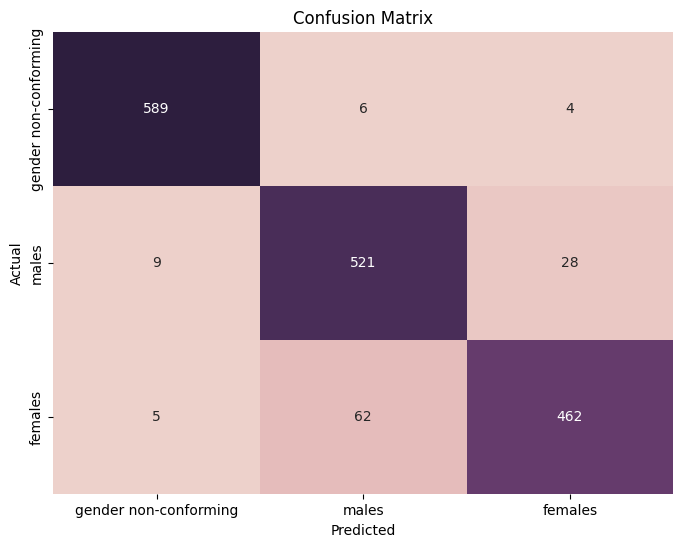

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(metrics.confusion_matrix(y_test, model_predictions), annot=True, fmt = 'd', cmap=sns.cubehelix_palette(as_cmap=True),
            cbar=False,
            xticklabels=['gender non-conforming', 'males', 'females'],
            yticklabels =['gender non-conforming', 'males', 'females']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Axes: >

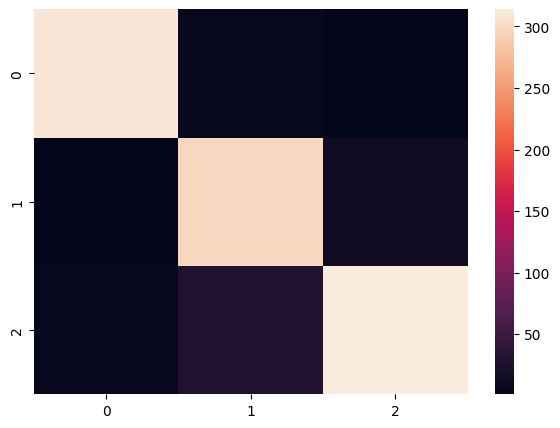

In [ ]:
import seaborn as sns
plt.figure(1, figsize=(7,5))
sns.heatmap(metrics.confusion_matrix(y_test, model_predictions))

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
X_train = train_gen.flow_from_directory((r"C:\Users\Admin\Documents\TESI DATASET\new_dataset\dataset_images\folder_of_images\train"), target_size=(224,224), batch_size=32)
X_test = test_gen.flow_from_directory((r"C:\Users\Admin\Documents\TESI DATASET\new_dataset\dataset_images\folder_of_images\test"), target_size=(224,224), batch_size=32)
y_train = train_df['gender']
y_test = test_df['gender']

NameError: name 'train_gen' is not defined

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
%matplotlib inline



def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn([r"C:\Users\Admin\Documents\TESI DATASET\dataset_train_test\test\005066.jpg"])

In [ ]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    images[0].astype('double'),
    model.predict,
    top_labels=30,
    hide_color=0,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 619ms/step


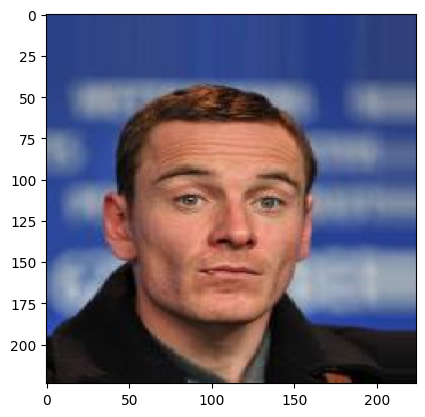

In [ ]:
plt.imshow(images[0].astype("uint8"))

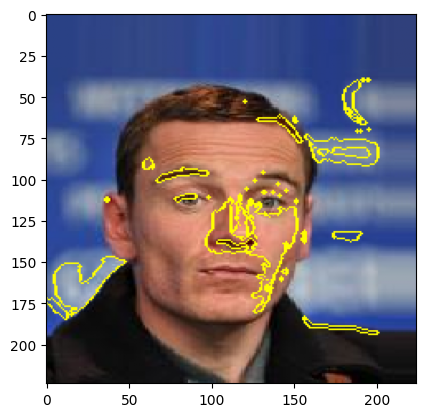

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=12, hide_rest=False)
plt.imshow(mark_boundaries(temp.astype("uint8"), mask))

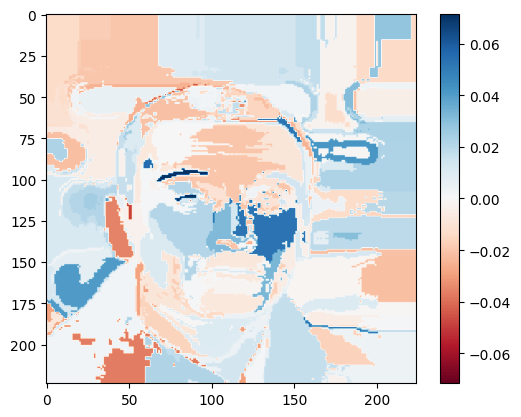

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
explanation.top_labels

[0, 2, 1]